In [151]:
# GPU로 Tesla T4가 준비돼있습니다.
!nvidia-smi

Mon Jul  1 05:59:14 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |    898MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [152]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

%matplotlib inline

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


# Step 1. 데이터 가져오기 & 전처리

## 1-1) 데이터 가져오기

In [153]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


## 1-2) 데이터 전처리

In [154]:
# 중복 제거
cleaned_corpus = list(set(raw))

In [155]:
#10~150 범위의 문장만 선택 나머지는 제거
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus 
                   if (len(s) < max_len) & (len(s) >= min_len)]

# Step 2. SentencePiece 설치하기

## 2-1) tokenize() 

In [156]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

## 2-2) SentencePiece 모델을 학습 및 활용

In [157]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Jul  1 05:59 korean_spm.model
-rw-r--r-- 1 root root 146213 Jul  1 05:59 korean_spm.vocab


In [158]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# Step 3. Tokenizer 함수 작성

In [159]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post')

    return tensor, word_index, index_word

# Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

## 4-1) 데이터 불러오기

In [160]:
import os
path_to_file = 'NaverReviewData/ratings.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 200001
Example:
>> id	document	label
>> 9468781	어?생각없이 봤는데 상당한 수작.일본영화 10년내 최고로 마음에 들었다.강렬한 임팩트가 일품.	1
>> 6809191	마치 바다속 , 아쿠아리움속으로 들어간듯한 느낌의 영화 어린자녀들에게 강추!!	1
>> 8255656	재밌습니다.재밌습니다.	1
>> 8499726	너무너무재밌게보고있어요! 중간부터 본방사수했지만 스토리가 탄탄하고 흥미진진해서 1화부터 다찾아서 봤네요 배우들 연기도 어디하나빠지는데가없네요 요새는 수백향만챙겨봐요	1


## 4-2) 데이터 분석

문장의 최단 길이: 8
문장의 최장 길이: 156
문장의 평균 길이: 45
데이터 총량: 200001


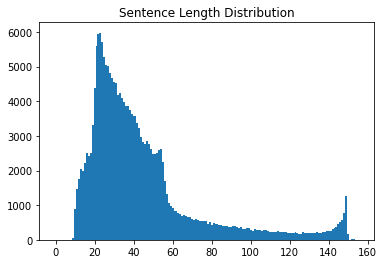

In [161]:
import numpy as np
import matplotlib.pyplot as plt


min_len = 999 
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))
print("데이터 총량:",len(raw))

#각 길이를 가진 문장의 개수 저장
sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

#X 문장길이 / Y : 문장의 개수    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 4-3) SentencePiece 적용한 토큰화

In [162]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus[1:]:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post')

    return tensor, word_index, index_word

tensor, word_index, index_word = sp_tokenize(s, raw)

In [163]:
print(len(tensor))

200000


In [164]:
tensor[0]

array([ 159, 2820, 1715, 3630,  549,  666, 1817,  146,   14,  679, 4609,
       6173,   30,  295,    0,   71,  514,    0,   51,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

## 4-4) 데이터 분할

In [165]:
labels = []
for line in raw[1:]:
    label = line.split('\t')[2]  # 탭 문자로 분리 후 첫 번째 요소(레이블) 선택
    labels.append(int(label))  # 레이블을 정수형으로 변환하여 리스트에 추가

print(len(labels))  # 처음 10개 레이블 출력

tensor_train = tensor[:200000]
labels_train = labels[:200000]

200000


In [166]:
#Train data와 Test data 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tensor_train, 
                                                    labels_train, 
                                                    test_size=0.2, 
                                                    stratify = labels_train, 
                                                    random_state=42)

In [167]:
y_train = np.array(y_train, dtype=np.float32)  # 레이블 데이터 타입 변환
y_test = np.array(y_test, dtype=np.float32)

In [168]:
labels, counts = np.unique(y_train,return_counts = True)
counts

array([80000, 80000])

In [169]:
labels, counts = np.unique(y_test,return_counts = True)
counts

array([20000, 20000])

## 4-5)모델학습

In [173]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding # Embedding 레이어 직접 import


model = tf.keras.Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, 
                             output_dim=128))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [175]:
model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))

5000/5000 [==============================] - 33s 6ms/step - loss: 0.6933 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5000


# Step 5. KoNLPy 형태소 분석기를 사용

In [176]:
from konlpy.tag import Mecab

mecab = Mecab()

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in raw[1:]:
    mecab_corpus.append(mecab_split(kor))

In [177]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 261053


In [178]:
X_train, X_test, y_train, y_test = train_test_split(mecab_tensor, 
                                                    labels_train, 
                                                    test_size=0.2, 
                                                    stratify = labels_train, 
                                                    random_state=42)

In [179]:
y_train = np.array(y_train, dtype=np.float32)  # 레이블 데이터 타입 변환
y_test = np.array(y_test, dtype=np.float32)

In [180]:
model = tf.keras.Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, 
                             output_dim=128))
model.add(tf.keras.layers.SimpleRNN(32))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [181]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [182]:
model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))

5000/5000 [==============================] - 401s 80ms/step - loss: 0.4020 - accuracy: 0.8057 - val_loss: 0.2824 - val_accuracy: 0.8930
